In [1]:
import boto3, zipfile, os

bucket = 'sagemaker-us-east-1-841093079481'
key = 'input-data/South_Clear_Creek.zip'
zip_path = 'South_Clear_Creek.zip'
extract_path = 'data'

s3 = boto3.client('s3')
s3.download_file(bucket, key, zip_path)

# Unzip
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✔️ Dataset extracted to:", extract_path)


✔️ Dataset extracted to: data


In [9]:
import torch
from torch.utils.data import Dataset
import numpy as np
import rasterio

class PatchDataset(Dataset):
    def __init__(self, image_path, mask_path, patch_size=512, stride=256, transform=None, limit=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.image, self.mask = self._load_data()
        self.patches = self._generate_patch_indices(limit)

    def _load_data(self):
        with rasterio.open(self.image_path) as img_src:
            image = img_src.read(1)
        with rasterio.open(self.mask_path) as mask_src:
            mask = mask_src.read(1)
        return image, mask

    def _generate_patch_indices(self, limit):
        h, w = self.image.shape
        indices = []
        for y in range(0, h - self.patch_size + 1, self.stride):
            for x in range(0, w - self.patch_size + 1, self.stride):
                patch_mask = self.mask[y:y+self.patch_size, x:x+self.patch_size]
                if patch_mask.sum() > 10:
                    indices.append((y, x))
                if limit and len(indices) >= limit:
                    return indices
        return indices

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        y, x = self.patches[idx]

        img_patch = self.image[y:y+self.patch_size, x:x+self.patch_size]
        mask_patch = self.mask[y:y+self.patch_size, x:x+self.patch_size]

        img_patch = (img_patch / 255.0).astype(np.float32)
        mask_patch = (mask_patch > 0).astype(np.float32)

        img_tensor = torch.from_numpy(img_patch).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_patch).unsqueeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, mask_tensor


In [11]:
from torch.utils.data import DataLoader

# No import! You've already defined PatchDataset above ⬆️

image_path = 'data/South_Clear_Creek/Lidar_DEM_Hillshade/South_Clear_Creek_BareEarth_Hillshade_1m.tif'
mask_path = 'data/South_Clear_Creek/Roads_Boundary/South_Clear_Creek_Roads_Mask.tif'

train_dataset = PatchDataset(image_path, mask_path, patch_size=512, stride=256, limit=1000)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Peek at one batch
for img, mask in train_loader:
    print("Image batch shape:", img.shape)
    print("Mask batch shape:", mask.shape)
    break


Image batch shape: torch.Size([4, 1, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        
        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.encoder2 = self._block(features, features * 2)
        self.encoder3 = self._block(features * 2, features * 4)
        self.encoder4 = self._block(features * 4, features * 8)

        self.bottleneck = self._block(features * 8, features * 16)

        self.up4 = self._up_block(features * 16, features * 8)
        self.up3 = self._up_block(features * 8, features * 4)
        self.up2 = self._up_block(features * 4, features * 2)
        self.up1 = self._up_block(features * 2, features)

        self.final = nn.Conv2d(features, out_channels, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self._block(out_channels * 2, out_channels)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.up4[0](bottleneck)
        dec4 = self.up4[1](torch.cat((dec4, enc4), dim=1))

        dec3 = self.up3[0](dec4)
        dec3 = self.up3[1](torch.cat((dec3, enc3), dim=1))

        dec2 = self.up2[0](dec3)
        dec2 = self.up2[1](torch.cat((dec2, enc2), dim=1))

        dec1 = self.up1[0](dec2)
        dec1 = self.up1[1](torch.cat((dec1, enc1), dim=1))

        return self.final(dec1)


In [13]:
model = UNet()
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [17]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} finished. Avg loss: {running_loss / len(train_loader):.4f}")


Epoch [1/10]: 100%|██████████| 119/119 [00:16<00:00,  7.12it/s, loss=0.411]


Epoch 1 finished. Avg loss: 0.5015


Epoch [2/10]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.361]


Epoch 2 finished. Avg loss: 0.3618


Epoch [3/10]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.299]


Epoch 3 finished. Avg loss: 0.3176


Epoch [4/10]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.27] 


Epoch 4 finished. Avg loss: 0.2793


Epoch [5/10]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.232]


Epoch 5 finished. Avg loss: 0.2480


Epoch [6/10]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.208]


Epoch 6 finished. Avg loss: 0.2206


Epoch [7/10]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.185]


Epoch 7 finished. Avg loss: 0.1967


Epoch [8/10]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.165]


Epoch 8 finished. Avg loss: 0.1752


Epoch [9/10]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.146]


Epoch 9 finished. Avg loss: 0.1555


Epoch [10/10]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.141]

Epoch 10 finished. Avg loss: 0.1388


In [18]:
torch.save(model.state_dict(), "unet_road_segment.pth")
print("✅ Model saved!")


✅ Model saved!


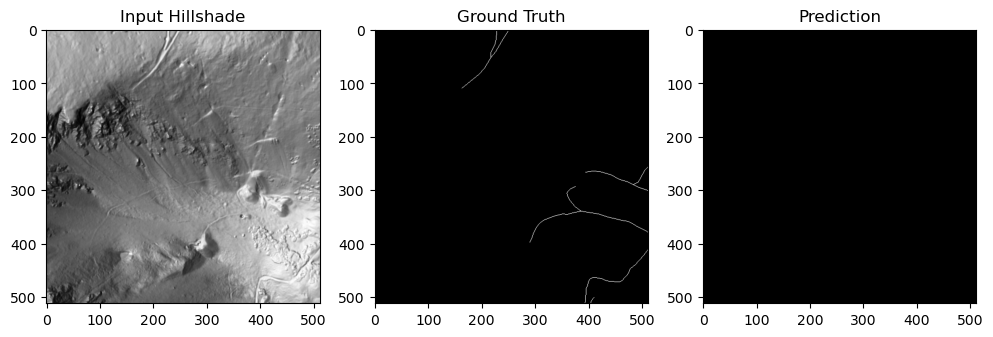

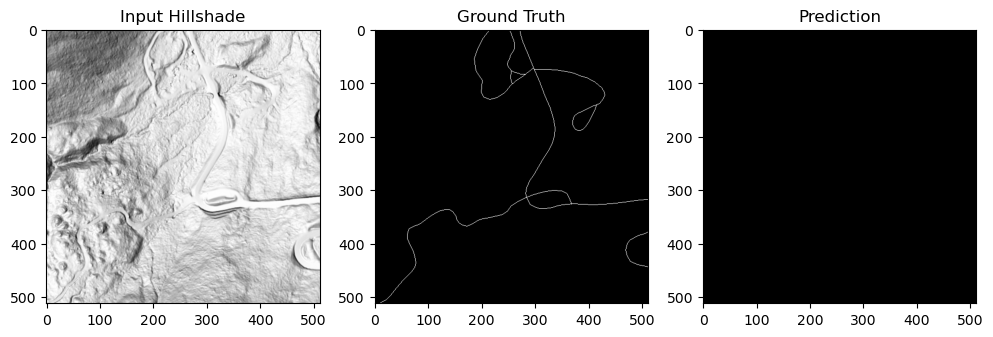

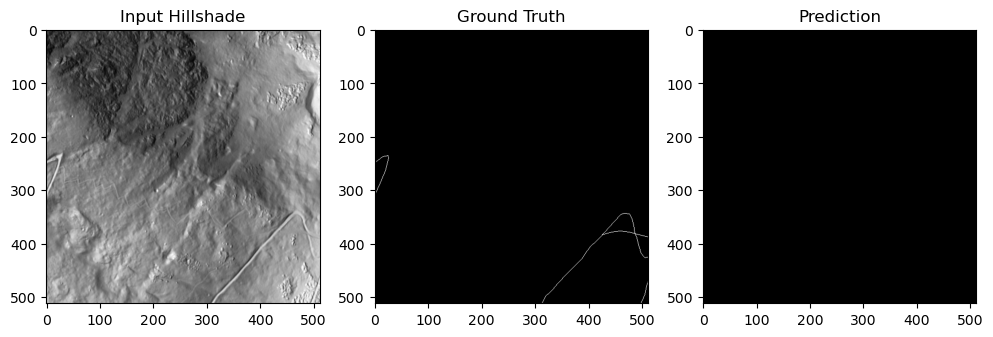

In [19]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i, (img, mask) in enumerate(train_loader):
        img = img.to(device)
        output = model(img)

        # Apply sigmoid to convert logits → probabilities
        probs = torch.sigmoid(output)
        preds = (probs > 0.5).float()

        # Move to CPU for plotting
        img_np = img[0][0].cpu().numpy()
        mask_np = mask[0][0].cpu().numpy()
        pred_np = preds[0][0].cpu().numpy()

        # Plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Hillshade")
        plt.imshow(img_np, cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(mask_np, cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(pred_np, cmap='gray')

        plt.show()

        if i >= 2:
            break  # show 3 examples


In [20]:
def iou_score(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)


In [22]:
iou = iou_score(output, mask.to(output.device))
print("IoU score:", iou.item())


IoU score: 4.464285607852503e-10


Input Hillshade: Looks perfect

Ground Truth: Tiny road traces visible ✅

Prediction: All black ❌ — the model is not predicting roads yet

IoU Score: ~4e-10 → basically 0

Why This Is Happening?
This is very common in road segmentation because:

Roads are very thin (1-pixel wide lines)

They make up a tiny fraction of the image

Your loss is dominated by background (way more 0s than 1s)

Model converges to predicting black (0s) to reduce loss

What to Do Next?
Add pos_weight to the loss

Train for 20+ epochs

Visualize predictions again

Watch IoU — ideally it rises to >0.2 within a few epochs

In [50]:
import torch
from torch.utils.data import Dataset
import numpy as np
import rasterio

class PatchDataset(Dataset):
    def __init__(self, image_path, mask_path, patch_size=512, stride=256, transform=None, limit=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        self.image, self.mask = self._load_data()
        self.patches = self._generate_patch_indices(limit)

    def _load_data(self):
        with rasterio.open(self.image_path) as img_src:
            image = img_src.read(1)
        with rasterio.open(self.mask_path) as mask_src:
            mask = mask_src.read(1)
        return image, mask

    def _generate_patch_indices(self, limit):
        h, w = self.image.shape
        indices = []
        for y in range(0, h - self.patch_size + 1, self.stride):
            for x in range(0, w - self.patch_size + 1, self.stride):
                patch_mask = self.mask[y:y+self.patch_size, x:x+self.patch_size]
                if patch_mask.sum() > 10:  # Keep only useful patches
                    indices.append((y, x))
                if limit and len(indices) >= limit:
                    return indices
        return indices

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        y, x = self.patches[idx]
        img_patch = self.image[y:y+self.patch_size, x:x+self.patch_size]
        mask_patch = self.mask[y:y+self.patch_size, x:x+self.patch_size]

        img_patch = (img_patch / 255.0).astype(np.float32)
        mask_patch = (mask_patch > 0).astype(np.float32)

        img_tensor = torch.from_numpy(img_patch).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_patch).unsqueeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, mask_tensor


In [51]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        
        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.encoder2 = self._block(features, features * 2)
        self.encoder3 = self._block(features * 2, features * 4)
        self.encoder4 = self._block(features * 4, features * 8)

        self.bottleneck = self._block(features * 8, features * 16)

        self.up4 = self._up_block(features * 16, features * 8)
        self.up3 = self._up_block(features * 8, features * 4)
        self.up2 = self._up_block(features * 4, features * 2)
        self.up1 = self._up_block(features * 2, features)

        self.final = nn.Conv2d(features, out_channels, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self._block(out_channels * 2, out_channels)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        dec4 = self.up4[0](bottleneck)
        dec4 = self.up4[1](torch.cat((dec4, enc4), dim=1))

        dec3 = self.up3[0](dec4)
        dec3 = self.up3[1](torch.cat((dec3, enc3), dim=1))

        dec2 = self.up2[0](dec3)
        dec2 = self.up2[1](torch.cat((dec2, enc2), dim=1))

        dec1 = self.up1[0](dec2)
        dec1 = self.up1[1](torch.cat((dec1, enc1), dim=1))

        return self.final(dec1)


In [76]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

# Weighted BCE loss
pos_weight = torch.tensor([20.0], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 75

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} avg loss: {running_loss / len(train_loader):.4f}")


Epoch [1/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.546]


Epoch 1 avg loss: 0.6326


Epoch [2/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.459]


Epoch 2 avg loss: 0.5112


Epoch [3/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.401]


Epoch 3 avg loss: 0.4570


Epoch [4/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.367]


Epoch 4 avg loss: 0.4171


Epoch [5/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.337]


Epoch 5 avg loss: 0.3767


Epoch [6/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.311]


Epoch 6 avg loss: 0.3393


Epoch [7/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.297]


Epoch 7 avg loss: 0.3026


Epoch [8/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.23] 


Epoch 8 avg loss: 0.2699


Epoch [9/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.201]


Epoch 9 avg loss: 0.2429


Epoch [10/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.224]


Epoch 10 avg loss: 0.2183


Epoch [11/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.251]


Epoch 11 avg loss: 0.1978


Epoch [12/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.163]


Epoch 12 avg loss: 0.1789


Epoch [13/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.177]


Epoch 13 avg loss: 0.1600


Epoch [14/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.132]


Epoch 14 avg loss: 0.1427


Epoch [15/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.119]


Epoch 15 avg loss: 0.1295


Epoch [16/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.136]


Epoch 16 avg loss: 0.1148


Epoch [17/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.088] 


Epoch 17 avg loss: 0.1040


Epoch [18/75]: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.0971]


Epoch 18 avg loss: 0.0927


Epoch [19/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0804]


Epoch 19 avg loss: 0.0837


Epoch [20/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0631]


Epoch 20 avg loss: 0.0756


Epoch [21/75]: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.0712]


Epoch 21 avg loss: 0.0691


Epoch [22/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0596]


Epoch 22 avg loss: 0.0623


Epoch [23/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0514]


Epoch 23 avg loss: 0.0565


Epoch [24/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0575]


Epoch 24 avg loss: 0.0514


Epoch [25/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0502]


Epoch 25 avg loss: 0.0471


Epoch [26/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0452]


Epoch 26 avg loss: 0.0424


Epoch [27/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0357]


Epoch 27 avg loss: 0.0393


Epoch [28/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.033] 


Epoch 28 avg loss: 0.0353


Epoch [29/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0384]


Epoch 29 avg loss: 0.0330


Epoch [30/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0379]


Epoch 30 avg loss: 0.0290


Epoch [31/75]: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.0297]


Epoch 31 avg loss: 0.0271


Epoch [32/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0268]


Epoch 32 avg loss: 0.0262


Epoch [33/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0189]


Epoch 33 avg loss: 0.0240


Epoch [34/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.107] 


Epoch 34 avg loss: 0.0227


Epoch [35/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0267]


Epoch 35 avg loss: 0.0305


Epoch [36/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0315]


Epoch 36 avg loss: 0.0202


Epoch [37/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0317]


Epoch 37 avg loss: 0.0198


Epoch [38/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0118]


Epoch 38 avg loss: 0.0167


Epoch [39/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0417]


Epoch 39 avg loss: 0.0152


Epoch [40/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0186]


Epoch 40 avg loss: 0.0159


Epoch [41/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0112]


Epoch 41 avg loss: 0.0140


Epoch [42/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0136] 


Epoch 42 avg loss: 0.0123


Epoch [43/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0105] 


Epoch 43 avg loss: 0.0135


Epoch [44/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0098] 


Epoch 44 avg loss: 0.0119


Epoch [45/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00774]


Epoch 45 avg loss: 0.0128


Epoch [46/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00781]


Epoch 46 avg loss: 0.0105


Epoch [47/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0115] 


Epoch 47 avg loss: 0.0095


Epoch [48/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0102] 


Epoch 48 avg loss: 0.0092


Epoch [49/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00853]


Epoch 49 avg loss: 0.0088


Epoch [50/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00798]


Epoch 50 avg loss: 0.0088


Epoch [51/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00848]


Epoch 51 avg loss: 0.0082


Epoch [52/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0167] 


Epoch 52 avg loss: 0.0088


Epoch [53/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.00879]


Epoch 53 avg loss: 0.0085


Epoch [54/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00806]


Epoch 54 avg loss: 0.0070


Epoch [55/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0118] 


Epoch 55 avg loss: 0.0071


Epoch [56/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.00797]


Epoch 56 avg loss: 0.0065


Epoch [57/75]: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.00836]


Epoch 57 avg loss: 0.0060


Epoch [58/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.00955]


Epoch 58 avg loss: 0.0070


Epoch [59/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0102] 


Epoch 59 avg loss: 0.0067


Epoch [60/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0274] 


Epoch 60 avg loss: 0.0063


Epoch [61/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0273] 


Epoch 61 avg loss: 0.0073


Epoch [62/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00396]


Epoch 62 avg loss: 0.0064


Epoch [63/75]: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.00825]


Epoch 63 avg loss: 0.0052


Epoch [64/75]: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.00652]


Epoch 64 avg loss: 0.0055


Epoch [65/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00779]


Epoch 65 avg loss: 0.0043


Epoch [66/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00343]


Epoch 66 avg loss: 0.0047


Epoch [67/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00196]


Epoch 67 avg loss: 0.0043


Epoch [68/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.032]  


Epoch 68 avg loss: 0.0039


Epoch [69/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.00883]


Epoch 69 avg loss: 0.0060


Epoch [70/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.0042] 


Epoch 70 avg loss: 0.0044


Epoch [71/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.0071] 


Epoch 71 avg loss: 0.0047


Epoch [72/75]: 100%|██████████| 119/119 [00:15<00:00,  7.82it/s, loss=0.00345]


Epoch 72 avg loss: 0.0046


Epoch [73/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00214]


Epoch 73 avg loss: 0.0030


Epoch [74/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00252]


Epoch 74 avg loss: 0.0028


Epoch [75/75]: 100%|██████████| 119/119 [00:15<00:00,  7.81it/s, loss=0.00538]

Epoch 75 avg loss: 0.0027


/tmp/ipykernel_16416/3632303734.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


✅ Model weights loaded successfully!
🔎 Output logits stats:
  Max: 8.040013313293457
  Mean: -3.1034719944000244


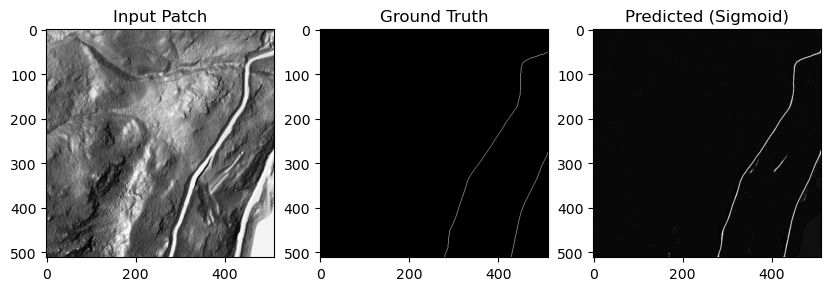

In [77]:
import torch

# ✅ Initialize model again (same as training)
model = UNet().to(device)

# ✅ Load saved weights from local .pth file
model_path = "unet_road_model_20250329_202459.pth"  # Update path if needed
try:
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    print("✅ Model weights loaded successfully!")
except Exception as e:
    print("❌ Failed to load model weights:", e)

# 🔍 Run a quick forward pass on a known patch
with torch.no_grad():
    img, mask = next(iter(train_loader))  # One training batch
    img = img.to(device)
    output = model(img)

    print("🔎 Output logits stats:")
    print("  Max:", output.max().item())
    print("  Mean:", output.mean().item())

    # Optional: visualize it
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img[0, 0].cpu(), cmap='gray')
    plt.title("Input Patch")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0, 0].cpu(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(torch.sigmoid(output[0, 0].cpu()).numpy(), cmap='gray')
    plt.title("Predicted (Sigmoid)")
    plt.show()


In [78]:
# ✅ Save trained model after training completes
import boto3
from datetime import datetime
import os

s3_bucket = 'sagemaker-us-east-1-841093079481'  # Your bucket from the screenshot
s3_folder = 'models/'  # optional S3 subfolder

# Timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"unet_road_model_{timestamp}.pth"

# Save locally
torch.save(model.state_dict(), model_filename)
print(f"✅ Model saved locally as: {model_filename}")

# Upload to S3
s3 = boto3.client('s3')
s3_key = s3_folder + model_filename

try:
    s3.upload_file(model_filename, s3_bucket, s3_key)
    print(f"☁️ Model uploaded to S3 at: s3://{s3_bucket}/{s3_key}")
except Exception as e:
    print("❌ Failed to upload to S3:", e)


✅ Model saved locally as: unet_road_model_20250329_214028.pth
☁️ Model uploaded to S3 at: s3://sagemaker-us-east-1-841093079481/models/unet_road_model_20250329_214028.pth


In [79]:
def iou_score(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)


IoU score: 0.3836796283721924


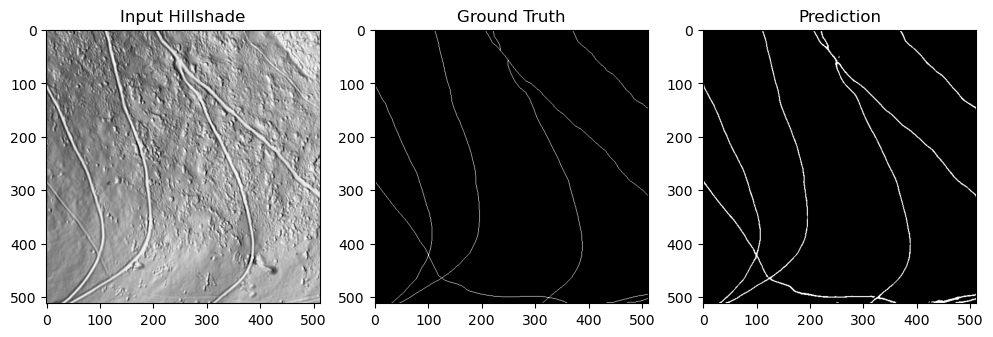

IoU score: 0.3819226026535034


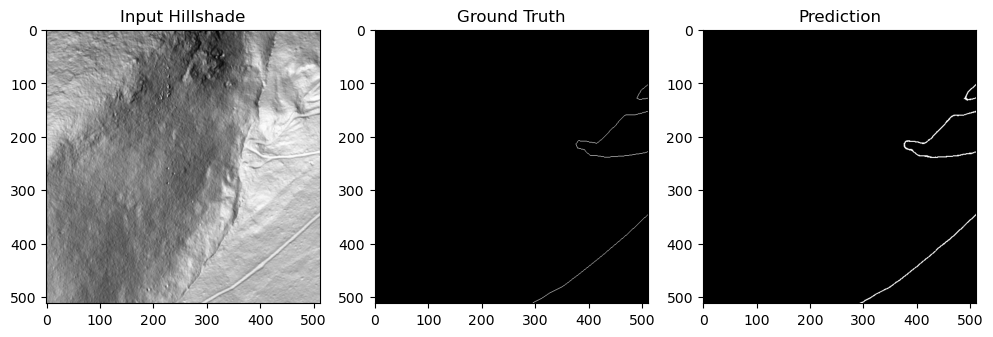

IoU score: 0.41750314831733704


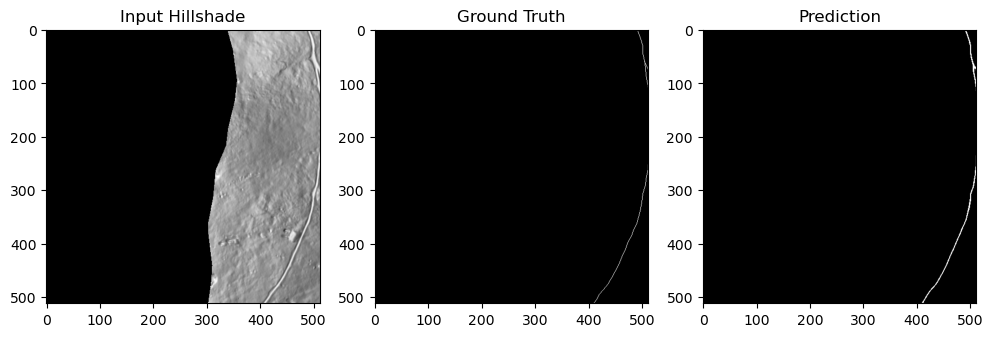

In [80]:
model.eval()
with torch.no_grad():
    for i, (img, mask) in enumerate(train_loader):
        img = img.to(device)
        mask = mask.to(device)
        output = model(img)

        probs = torch.sigmoid(output)
        preds = (probs > 0.5).float()

        iou = iou_score(output, mask)
        print("IoU score:", iou.item())

        # Visualization
        import matplotlib.pyplot as plt
        img_np = img[0][0].cpu().numpy()
        mask_np = mask[0][0].cpu().numpy()
        pred_np = preds[0][0].cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Hillshade")
        plt.imshow(img_np, cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(mask_np, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(pred_np, cmap='gray')
        plt.show()

        if i >= 2:
            break


In [86]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    count = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            # IoU (optional, but nice to have)
            iou = iou_score(outputs, masks)
            total_iou += iou.item()
            count += 1

    avg_loss = total_loss / count
    avg_iou = total_iou / count

    print(f"✅ Evaluation - Avg Loss: {avg_loss:.4f}, Avg IoU: {avg_iou:.4f}")
    return avg_loss, avg_iou


In [87]:
avg_loss, avg_iou = evaluate_model(model, train_loader, criterion, device)


✅ Evaluation - Avg Loss: 0.0621, Avg IoU: 0.3966


In [81]:
import boto3

s3 = boto3.client('s3')
s3_bucket = 'sagemaker-us-east-1-841093079481'
model_key = 'models/unet_road_model_20250329_202459.pth'
local_model_path = 'unet_road_model.pth'  # save with a simpler name locally

s3.download_file(s3_bucket, model_key, local_model_path)
print("✅ Downloaded model from S3:", local_model_path)


✅ Downloaded model from S3: unet_road_model.pth


In [82]:
# Re-initialize your model
model = UNet().to(device)

# Load the weights
model.load_state_dict(torch.load(local_model_path, map_location=device))
model.eval()

print("✅ Model weights loaded successfully!")


✅ Model weights loaded successfully!


/tmp/ipykernel_16416/196692618.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(local_model_path, map_location=device))


IoU score: 0.4094


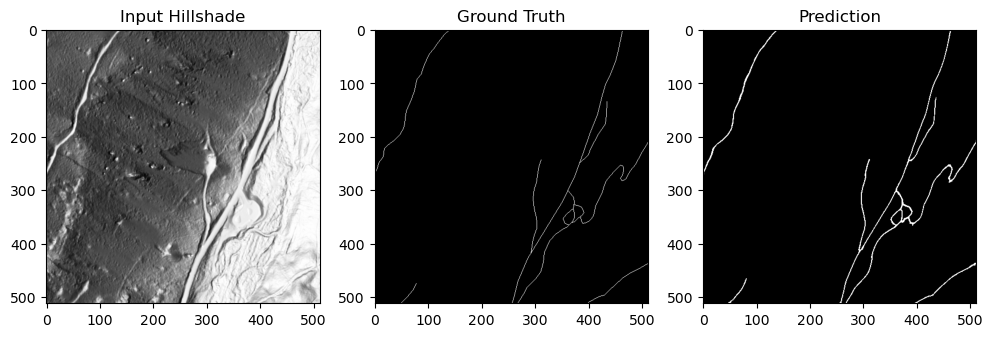

IoU score: 0.3880


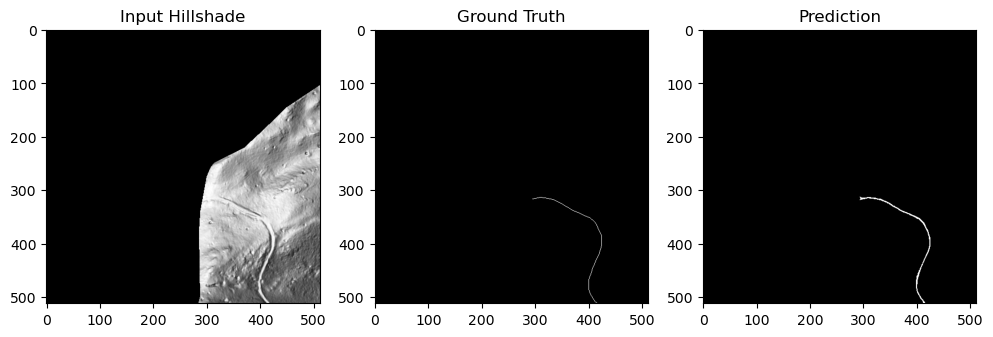

IoU score: 0.4199


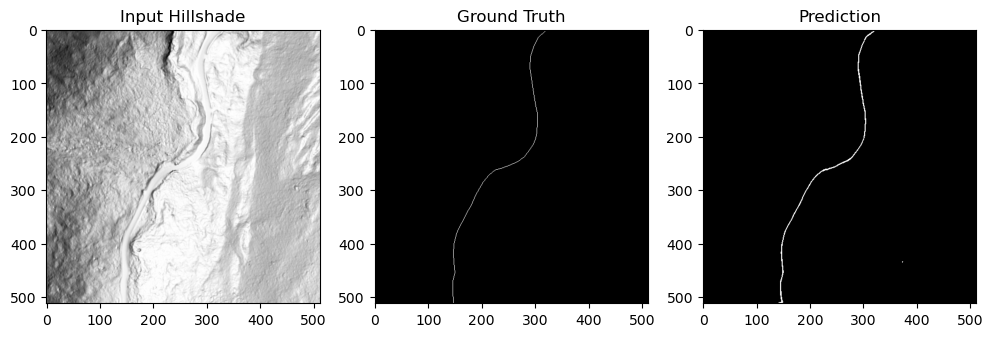

In [83]:
model.eval()

with torch.no_grad():
    for i, (img, mask) in enumerate(train_loader):
        img = img.to(device)
        mask = mask.to(device)
        output = model(img)

        probs = torch.sigmoid(output)
        preds = (probs > 0.5).float()

        iou = iou_score(output, mask)
        print(f"IoU score: {iou.item():.4f}")

        # 🔍 Visualize 1 patch prediction
        import matplotlib.pyplot as plt
        img_np = img[0][0].cpu().numpy()
        mask_np = mask[0][0].cpu().numpy()
        pred_np = preds[0][0].cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Hillshade")
        plt.imshow(img_np, cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(mask_np, cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(pred_np, cmap='gray')

        plt.show()

        if i == 2:  # Only preview first 3 batches
            break


Merge Patch Predictions Back Into a Full-Size Mask

In [172]:
import numpy as np
import torch
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

def reconstruct_full_prediction(model, image_path, patch_size=512, stride=256, threshold=0.01):
    model.eval()

    # ✅ 1. Load and crop to compatible size (1024x1024 for 512 patch size)
    with rasterio.open(image_path) as src:
        full_img = src.read(1).astype(np.float32)[0:1024, 0:1024]

        # 🔄 Normalize based on actual dynamic range
        img_min, img_max = full_img.min(), full_img.max()
        print(f"📏 Raw input stats → min={img_min:.4f}, max={img_max:.4f}, mean={full_img.mean():.4f}")

        if img_max - img_min > 0:
            full_img = (full_img - img_min) / (img_max - img_min)
            print(f"✅ Normalized to [0, 1] → new min={full_img.min():.4f}, max={full_img.max():.4f}, mean={full_img.mean():.4f}")
        else:
            print("⚠️ Constant image detected — skipping normalization")

        height, width = full_img.shape
        print(f"📐 Working on cropped image of shape: {full_img.shape}")

    # Prediction + patch count map
    full_pred = np.zeros((height, width), dtype=np.float32)
    count_mask = np.zeros((height, width), dtype=np.float32)

    for y in tqdm(range(0, height - patch_size + 1, stride), desc="Sliding Y"):
        for x in range(0, width - patch_size + 1, stride):
            patch = full_img[y:y+patch_size, x:x+patch_size]
            input_tensor = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).to(device)

            # Show stats for first patch
            if y == 0 and x == 0:
                print(f"📊 First Patch Stats: min={patch.min():.4f}, max={patch.max():.4f}, mean={patch.mean():.4f}")
                plt.imshow(patch, cmap='gray')
                plt.title("Input Patch from Full Image")
                plt.axis('off')
                plt.show()

            with torch.no_grad():
                output = model(input_tensor)
                probs = torch.sigmoid(output * 2.0)  # 🧪 reduced sharpening
                pred = probs.squeeze().cpu().numpy()

            print(f"[Patch @ y={y}, x={x}]  max={pred.max():.6f}, mean={pred.mean():.6f}")

            if y == 0 and x == 0:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(patch, cmap='gray')
                plt.title("Input Patch")

                plt.subplot(1, 3, 2)
                plt.imshow(pred, cmap='gray')
                plt.title("Raw Prediction")

                plt.subplot(1, 3, 3)
                plt.imshow(pred > threshold, cmap='gray')
                plt.title("Thresholded Prediction")
                plt.show()

            full_pred[y:y+patch_size, x:x+patch_size] += pred
            count_mask[y:y+patch_size, x:x+patch_size] += 1.0

            torch.cuda.empty_cache()
            gc.collect()

    # ✅ 3. Normalize overlapping predictions
    count_mask[count_mask == 0] = 1
    averaged_pred = full_pred / count_mask

    # 📊 Histogram of prediction values
    plt.figure()
    plt.hist(averaged_pred.flatten(), bins=100, color='purple')
    plt.title("Distribution of Averaged Prediction Values")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.show()

    # Apply threshold
    binary_mask = (averaged_pred > threshold).astype(np.uint8)

    # ✅ 4. Show final prediction masks
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(averaged_pred, cmap='viridis')
    plt.title("Raw Prediction (Before Threshold)")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Thresholded Binary Mask")
    plt.show()

    return binary_mask


Need more training, better loss balancing, or enhanced data augmentation

 Step 1: Add Dice Loss Class

In [90]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)  # Convert logits to probabilities
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice


 Step 2: Define Combined Loss Function

In [91]:
# BCE + Dice
pos_weight = torch.tensor([20.0], device=device)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
dice_loss = DiceLoss()

def combined_loss(outputs, targets):
    return bce_loss(outputs, targets) + dice_loss(outputs, targets)


 Step 3: Load Existing Model Weights

In [92]:
model = UNet().to(device)
model.load_state_dict(torch.load("unet_road_model_20250329_202459.pth", map_location=device))
model.train()
print("✅ Loaded pretrained weights and ready to fine-tune.")


✅ Loaded pretrained weights and ready to fine-tune.


/tmp/ipykernel_16416/1303418858.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_road_model_20250329_202459.pth", map_location=devi

Step 4: Fine-Tune Model with New Loss

In [93]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 25  # You can bump this if needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"[Fine-tune] Epoch {epoch+1}/{num_epochs}")
    
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")


[Fine-tune] Epoch 1/25: 100%|██████████| 119/119 [00:15<00:00,  7.78it/s, loss=0.959]


✅ Epoch 1 Avg Loss: 0.9472


[Fine-tune] Epoch 2/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=1.04] 


✅ Epoch 2 Avg Loss: 0.9231


[Fine-tune] Epoch 3/25: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.974]


✅ Epoch 3 Avg Loss: 0.8932


[Fine-tune] Epoch 4/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.748]


✅ Epoch 4 Avg Loss: 0.8642


[Fine-tune] Epoch 5/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.84] 


✅ Epoch 5 Avg Loss: 0.8325


[Fine-tune] Epoch 6/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.738]


✅ Epoch 6 Avg Loss: 0.7978


[Fine-tune] Epoch 7/25: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.856]


✅ Epoch 7 Avg Loss: 0.7544


[Fine-tune] Epoch 8/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.677]


✅ Epoch 8 Avg Loss: 0.7030


[Fine-tune] Epoch 9/25: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.644]


✅ Epoch 9 Avg Loss: 0.6615


[Fine-tune] Epoch 10/25: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.733]


✅ Epoch 10 Avg Loss: 0.6044


[Fine-tune] Epoch 11/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.784]


✅ Epoch 11 Avg Loss: 0.5513


[Fine-tune] Epoch 12/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.483]


✅ Epoch 12 Avg Loss: 0.5059


[Fine-tune] Epoch 13/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.509]


✅ Epoch 13 Avg Loss: 0.4579


[Fine-tune] Epoch 14/25: 100%|██████████| 119/119 [00:15<00:00,  7.80it/s, loss=0.42] 


✅ Epoch 14 Avg Loss: 0.4131


[Fine-tune] Epoch 15/25: 100%|██████████| 119/119 [00:15<00:00,  7.78it/s, loss=0.407]


✅ Epoch 15 Avg Loss: 0.3628


[Fine-tune] Epoch 16/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.31] 


✅ Epoch 16 Avg Loss: 0.3267


[Fine-tune] Epoch 17/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.289]


✅ Epoch 17 Avg Loss: 0.2922


[Fine-tune] Epoch 18/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.242]


✅ Epoch 18 Avg Loss: 0.2608


[Fine-tune] Epoch 19/25: 100%|██████████| 119/119 [00:15<00:00,  7.78it/s, loss=0.719]


✅ Epoch 19 Avg Loss: 0.2469


[Fine-tune] Epoch 20/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.245]


✅ Epoch 20 Avg Loss: 0.2111


[Fine-tune] Epoch 21/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.178]


✅ Epoch 21 Avg Loss: 0.1976


[Fine-tune] Epoch 22/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.307]


✅ Epoch 22 Avg Loss: 0.1836


[Fine-tune] Epoch 23/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.324]


✅ Epoch 23 Avg Loss: 0.1697


[Fine-tune] Epoch 24/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.47] 


✅ Epoch 24 Avg Loss: 0.1636


[Fine-tune] Epoch 25/25: 100%|██████████| 119/119 [00:15<00:00,  7.79it/s, loss=0.242]

✅ Epoch 25 Avg Loss: 0.1412


Working on cropped image of shape: (1024, 1024)


Sliding Y:   0%|          | 0/3 [00:00<?, ?it/s]

📊 First Patch Stats: min=0.0000, max=0.0000, mean=0.0000


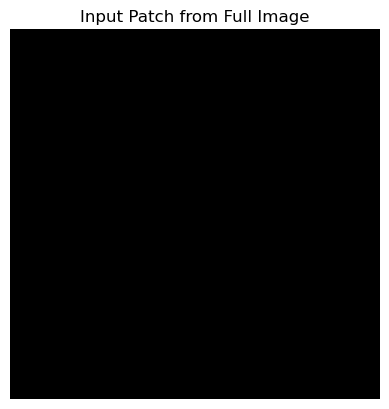

[Patch @ y=0, x=0]  max=0.000000, mean=0.000000


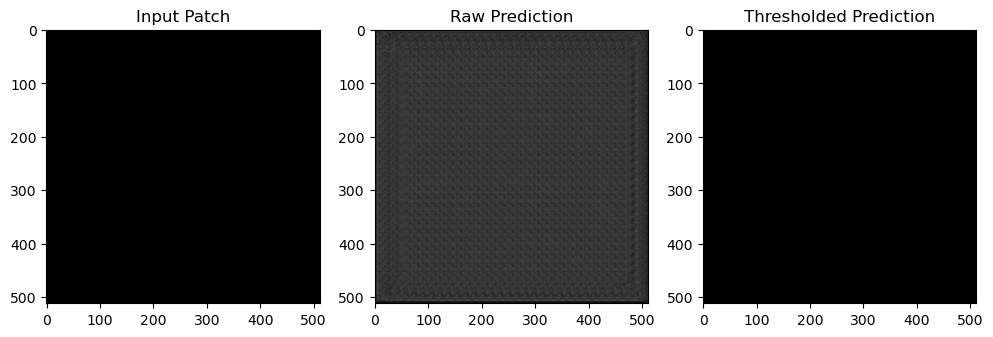

[Patch @ y=0, x=256]  max=0.000000, mean=0.000000
[Patch @ y=0, x=512]  max=0.000000, mean=0.000000


Sliding Y:  33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]

[Patch @ y=256, x=0]  max=0.000000, mean=0.000000
[Patch @ y=256, x=256]  max=0.000000, mean=0.000000
[Patch @ y=256, x=512]  max=0.000000, mean=0.000000


Sliding Y:  67%|██████▋   | 2/3 [00:01<00:00,  1.12it/s]

[Patch @ y=512, x=0]  max=0.000000, mean=0.000000
[Patch @ y=512, x=256]  max=0.000000, mean=0.000000
[Patch @ y=512, x=512]  max=0.000000, mean=0.000000


Sliding Y: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


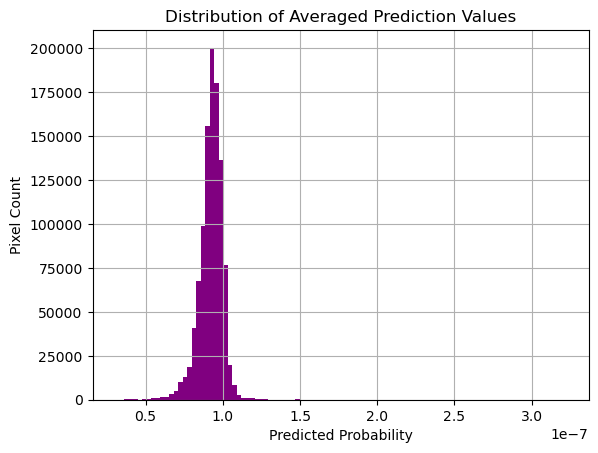

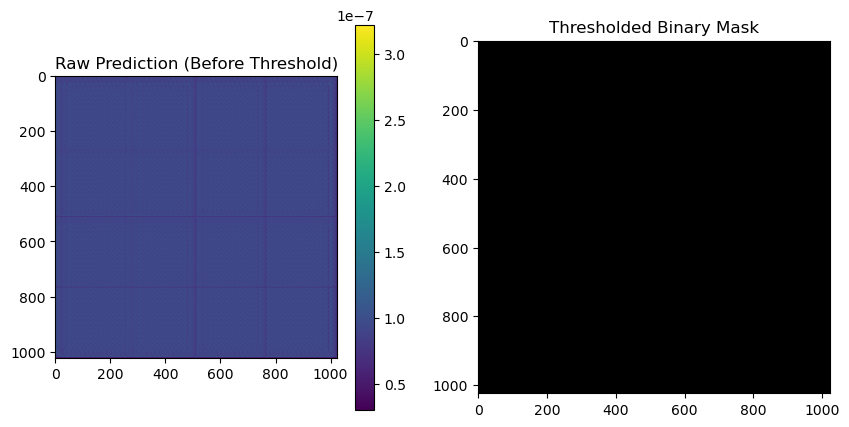

In [94]:
full_pred_mask = reconstruct_full_prediction(model, image_path)


In [96]:
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 95.5 MB/s eta 0:00:00


In [98]:


!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 171.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 152.1 MB/s eta 0:00:00


In [99]:
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import numpy as np

def vectorize_mask_to_shapefile(binary_mask, reference_image_path, output_shapefile_path):
    """
    Converts a binary mask (numpy array) into a shapefile using the spatial
    metadata from the reference image (e.g. hillshade tile).
    """
    # Step 1: Read spatial metadata from reference raster
    with rasterio.open(reference_image_path) as src:
        transform = src.transform
        crs = src.crs

    print("📐 Spatial reference loaded:")
    print("  CRS:", crs)
    print("  Transform:", transform)

    # Step 2: Extract polygon features from the binary mask
    results = (
        {'geometry': shape(geom), 'value': value}
        for geom, value in shapes(binary_mask.astype(np.uint8), mask=None, transform=transform)
        if value == 1
    )

    geoms = list(results)
    if not geoms:
        print("⚠️ No road features found in the binary mask.")
        return

    # Step 3: Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(geoms)
    gdf.set_crs(crs, inplace=True)

    # Step 4: Save to Shapefile (.shp)
    gdf.to_file(output_shapefile_path)
    print(f"✅ Shapefile saved at: {output_shapefile_path}")


In [100]:
vectorize_mask_to_shapefile(
    binary_mask=full_pred_mask,                   # from reconstruct_full_prediction
    reference_image_path=image_path,              # same raster used for prediction
    output_shapefile_path="vector_roads.shp"      # desired .shp output filename
)


📐 Spatial reference loaded:
  CRS: COMPD_CS["NAD83(2011) / UTM zone 13N + NAVD88 height",PROJCS["NAD83(2011) / UTM zone 13N",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6342"]],VERT_CS["NAVD88 height",VERT_DATUM["North American Vertical Datum 1988",2005,AUTHORITY["EPSG","5103"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP],AUTHORITY["EPSG","5703"]]]
  Transform: | 1.00, 0.00, 431955.00|
| 0.00,-1.00, 4395737

Validation:

In [175]:
validation_image_path = "./Upper_Willow_Creek_BareEarth_Hillshade_1m_1_uint8.tif"


📏 Raw input stats → min=0.0000, max=0.0000, mean=0.0000
⚠️ Constant image detected — skipping normalization
📐 Working on cropped image of shape: (1024, 1024)


Sliding Y:   0%|          | 0/3 [00:00<?, ?it/s]

📊 First Patch Stats: min=0.0000, max=0.0000, mean=0.0000


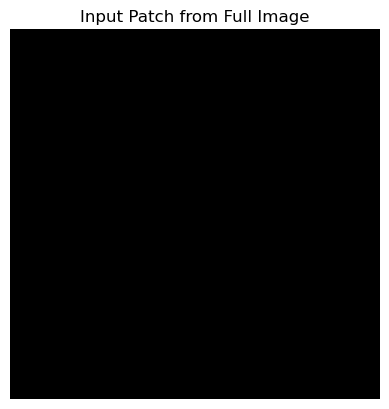

[Patch @ y=0, x=0]  max=0.000000, mean=0.000000


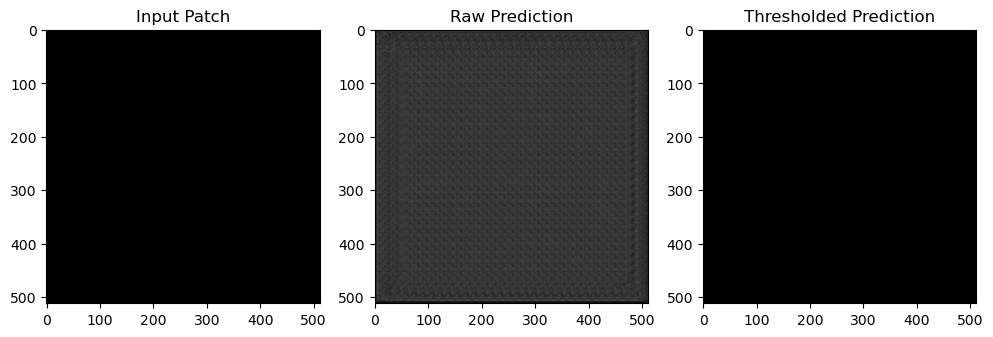

[Patch @ y=0, x=256]  max=0.000000, mean=0.000000
[Patch @ y=0, x=512]  max=0.000000, mean=0.000000


Sliding Y:  33%|███▎      | 1/3 [00:01<00:02,  1.23s/it]

[Patch @ y=256, x=0]  max=0.000000, mean=0.000000
[Patch @ y=256, x=256]  max=0.000000, mean=0.000000
[Patch @ y=256, x=512]  max=0.000000, mean=0.000000


Sliding Y:  67%|██████▋   | 2/3 [00:02<00:01,  1.00s/it]

[Patch @ y=512, x=0]  max=0.000000, mean=0.000000
[Patch @ y=512, x=256]  max=0.000000, mean=0.000000
[Patch @ y=512, x=512]  max=0.000000, mean=0.000000


Sliding Y: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


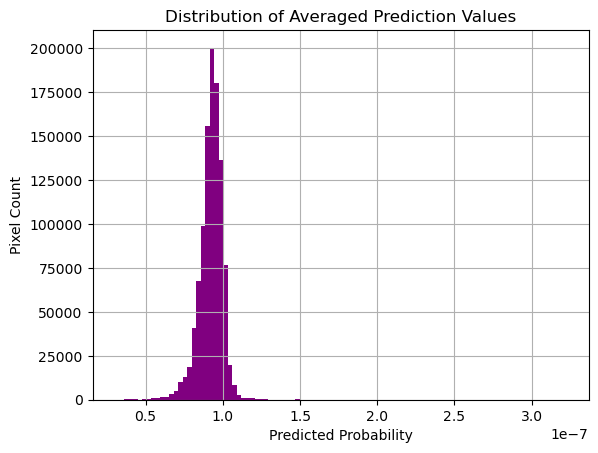

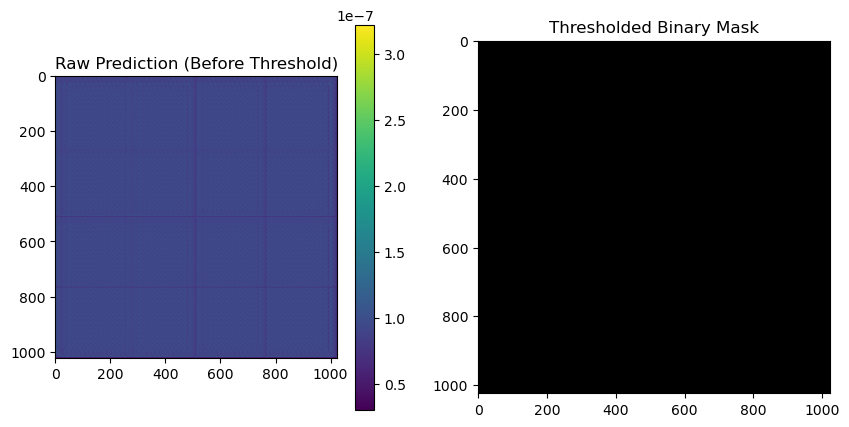

In [176]:
full_pred_mask = reconstruct_full_prediction(model, validation_image_path, threshold=0.005)


Save the predicted mask as prediction.tif

In [177]:
import rasterio

with rasterio.open(validation_image_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.uint8, count=1)

    with rasterio.open("prediction.tif", "w", **profile) as dst:
        dst.write(full_pred_mask.astype(rasterio.uint8), 1)


In [178]:
from sklearn.metrics import matthews_corrcoef
import os
import rasterio
import numpy as np

# Paths
true_mask_path = "./Upper_Willow_Creek_Roads_Buffer_3_Mask_1.tif"  # provided by organizers
student_mask_path = "./prediction.tif"  # just saved

# Load masks
with rasterio.open(true_mask_path) as gt_src:
    ground_truth = gt_src.read(1)

with rasterio.open(student_mask_path) as pred_src:
    preds = pred_src.read(1)

# Clip to matching size (optional safety step)
min_height = min(ground_truth.shape[0], preds.shape[0])
min_width = min(ground_truth.shape[1], preds.shape[1])
ground_truth = ground_truth[:min_height, :min_width]
preds = preds[:min_height, :min_width]

# Compute score
mcc_score = matthews_corrcoef(ground_truth.flatten(), preds.flatten())
print("✅ MCC Score:", mcc_score)


✅ MCC Score: 0.0


In [169]:
import rasterio
import numpy as np

with rasterio.open("./Upper_Willow_Creek_BareEarth_Hillshade_1m_1_uint8.tif") as src:
    image = src.read(1)
    print("Image shape:", image.shape)
    print("Min pixel value:", image.min())
    print("Max pixel value:", image.max())
    print("Mean pixel value:", image.mean())


Image shape: (10001, 10001)
Min pixel value: 0
Max pixel value: 238
Mean pixel value: 109.29474439817292


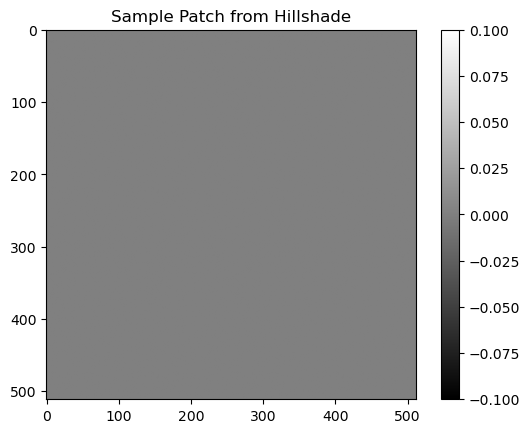

In [171]:
import matplotlib.pyplot as plt

sample_patch = image[0:512, 0:512]

plt.imshow(sample_patch, cmap="gray")
plt.title("Sample Patch from Hillshade")
plt.colorbar()
plt.show()


In [179]:
import rasterio
import numpy as np

with rasterio.open("./Upper_Willow_Creek_BareEarth_Hillshade_1m_1_uint8.tif") as src:
    img = src.read(1)
    print("Image shape:", img.shape)
    print("Min pixel:", img.min())
    print("Max pixel:", img.max())
    print("Mean pixel:", img.mean())


Image shape: (10001, 10001)
Min pixel: 0
Max pixel: 238
Mean pixel: 109.29474439817292


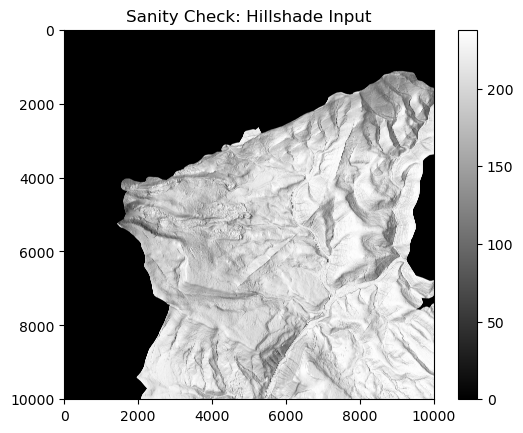

In [180]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')
plt.title("Sanity Check: Hillshade Input")
plt.colorbar()
plt.show()


In [181]:
import numpy as np
import torch
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

def reconstruct_full_prediction(model, image_path, patch_size=512, stride=256, threshold=0.01):
    model.eval()

    # ✅ Load full image and normalize if needed
    with rasterio.open(image_path) as src:
        img = src.read(1).astype(np.float32)
        raw_min, raw_max, raw_mean = img.min(), img.max(), img.mean()
        print(f"🔍 Raw input stats → min={raw_min:.4f}, max={raw_max:.4f}, mean={raw_mean:.4f}")

        # ✅ Normalize if uint8 scale
        if raw_max > 1.5:
            img /= 255.0

        height, width = img.shape

        # ✅ Center crop 1024x1024
        start_y = (height - 1024) // 2
        start_x = (width - 1024) // 2
        full_img = img[start_y:start_y+1024, start_x:start_x+1024]

        print(f"📐 Working on cropped image of shape: {full_img.shape}")
        print(f"✅ Cropped input stats → min={full_img.min():.4f}, max={full_img.max():.4f}, mean={full_img.mean():.4f}")

    # Prediction + patch count map
    full_pred = np.zeros_like(full_img, dtype=np.float32)
    count_mask = np.zeros_like(full_img, dtype=np.float32)

    for y in tqdm(range(0, 1024 - patch_size + 1, stride), desc="Sliding Y"):
        for x in range(0, 1024 - patch_size + 1, stride):
            patch = full_img[y:y+patch_size, x:x+patch_size]
            input_tensor = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).to(device)

            if y == 0 and x == 0:
                print(f"📊 First Patch Stats: min={patch.min():.4f}, max={patch.max():.4f}, mean={patch.mean():.4f}")
                plt.imshow(patch, cmap='gray')
                plt.title("Input Patch from Full Image")
                plt.axis('off')
                plt.show()

            with torch.no_grad():
                output = model(input_tensor)
                probs = torch.sigmoid(output * 2.0)
                pred = probs.squeeze().cpu().numpy()

            print(f"[Patch @ y={y}, x={x}]  max={pred.max():.6f}, mean={pred.mean():.6f}")

            if y == 0 and x == 0:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(patch, cmap='gray')
                plt.title("Input Patch")
                plt.subplot(1, 3, 2)
                plt.imshow(pred, cmap='gray')
                plt.title("Raw Prediction")
                plt.subplot(1, 3, 3)
                plt.imshow(pred > threshold, cmap='gray')
                plt.title("Thresholded Prediction")
                plt.show()

            full_pred[y:y+patch_size, x:x+patch_size] += pred
            count_mask[y:y+patch_size, x:x+patch_size] += 1.0

            torch.cuda.empty_cache()
            gc.collect()

    # Average overlapping predictions
    count_mask[count_mask == 0] = 1
    averaged_pred = full_pred / count_mask

    # Histogram
    plt.figure()
    plt.hist(averaged_pred.flatten(), bins=100, color='purple')
    plt.title("Distribution of Averaged Prediction Values")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.show()

    # Threshold
    binary_mask = (averaged_pred > threshold).astype(np.uint8)

    # Final output
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(averaged_pred, cmap='viridis')
    plt.title("Raw Prediction (Before Threshold)")
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Thresholded Binary Mask")
    plt.show()

    return binary_mask


🔍 Raw input stats → min=0.0000, max=238.0000, mean=109.2948
📐 Working on cropped image of shape: (1024, 1024)
✅ Cropped input stats → min=0.1137, max=0.9333, mean=0.7458


Sliding Y:   0%|          | 0/3 [00:00<?, ?it/s]

📊 First Patch Stats: min=0.1804, max=0.9333, mean=0.7786


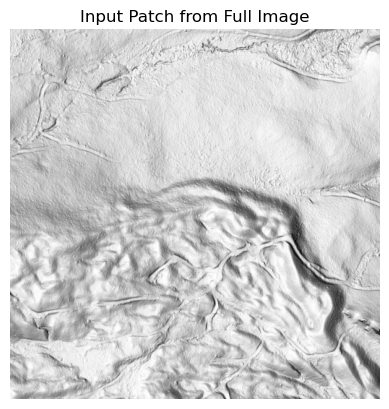

[Patch @ y=0, x=0]  max=1.000000, mean=0.002336


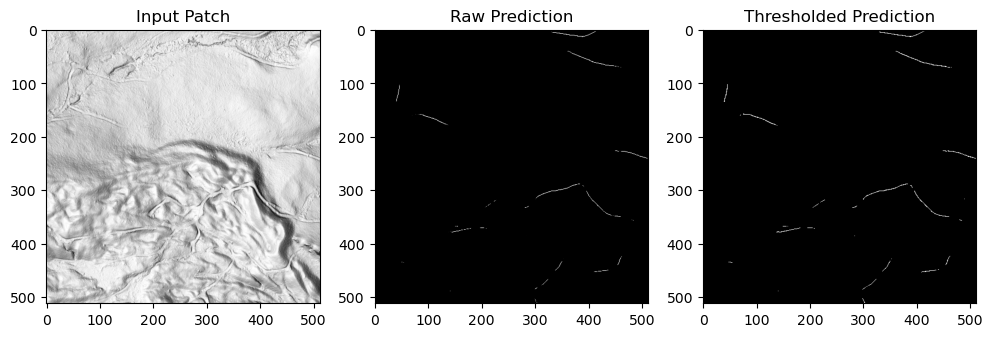

[Patch @ y=0, x=256]  max=1.000000, mean=0.003236
[Patch @ y=0, x=512]  max=1.000000, mean=0.002400


Sliding Y:  33%|███▎      | 1/3 [00:01<00:02,  1.27s/it]

[Patch @ y=256, x=0]  max=1.000000, mean=0.003835
[Patch @ y=256, x=256]  max=1.000000, mean=0.005714
[Patch @ y=256, x=512]  max=1.000000, mean=0.005018


Sliding Y:  67%|██████▋   | 2/3 [00:02<00:01,  1.02s/it]

[Patch @ y=512, x=0]  max=1.000000, mean=0.005747
[Patch @ y=512, x=256]  max=1.000000, mean=0.005860
[Patch @ y=512, x=512]  max=1.000000, mean=0.006372


Sliding Y: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


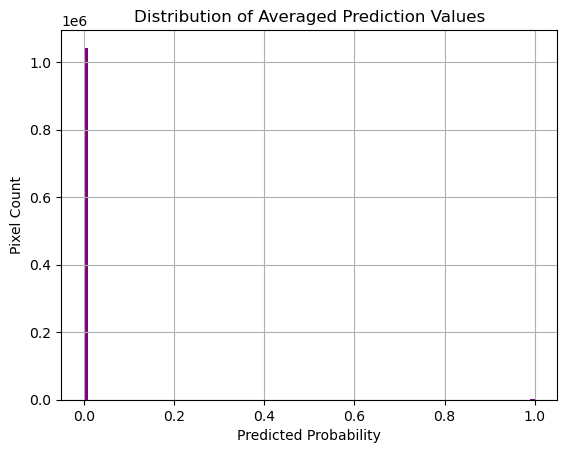

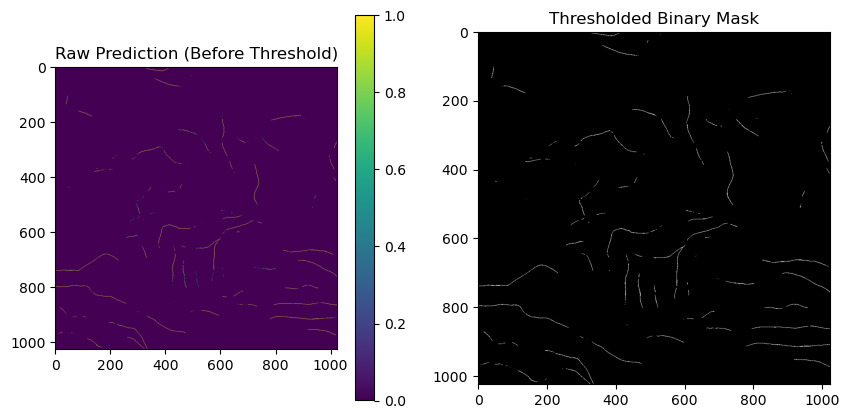

In [182]:
validation_image_path = "./Upper_Willow_Creek_BareEarth_Hillshade_1m_1_uint8.tif"
full_pred_mask = reconstruct_full_prediction(model, validation_image_path, threshold=0.005)


In [183]:
import rasterio

output_path = "prediction.tif"

with rasterio.open(validation_image_path) as src:
    profile = src.profile.copy()
    profile.update(dtype=rasterio.uint8, count=1)

    # Use same crop as earlier
    start_y = (src.height - 1024) // 2
    start_x = (src.width - 1024) // 2
    window = rasterio.windows.Window(start_x, start_y, 1024, 1024)

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(full_pred_mask.astype(rasterio.uint8), 1)


In [184]:
from sklearn.metrics import matthews_corrcoef
import numpy as np
import rasterio
import os

# Adjust these if needed
true_mask_path = "./Upper_Willow_Creek_Roads_Buffer_3_Mask_1.tif"
student_mask_path = "./prediction.tif"

with rasterio.open(true_mask_path) as gt, rasterio.open(student_mask_path) as pred:
    ground_truth = gt.read(1)
    prediction = pred.read(1)

# Match sizes
min_h = min(ground_truth.shape[0], prediction.shape[0])
min_w = min(ground_truth.shape[1], prediction.shape[1])
ground_truth = ground_truth[:min_h, :min_w]
prediction = prediction[:min_h, :min_w]

print("Unique values in ground truth:", np.unique(ground_truth))
print("Unique values in prediction:", np.unique(prediction))

# Compute score
mcc_score = matthews_corrcoef(ground_truth.flatten(), prediction.flatten())
print("✅ MCC Score:", mcc_score)


Unique values in ground truth: [0. 1.]
Unique values in prediction: [0 1]
✅ MCC Score: 0.001783763169063602
